# **Q-Learning (Reinforcement Learning) based Maze Solver**

## Required Libraries & Modules:

In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt
from ImgPreprocess import preprocess

## Agent of the Q-Learning Model:

In [12]:
class Agent:
    # defining Agent related functions and instances

    def __init__(self, i = 0, j = 0):
        # initailises the Agent object with passed coordinates (default: (0, 0))

        self.i = i
        self.j = j

    @property
    def loc(self):
        # returns the current location of the Agent in the maze as tuple

        return (self.i, self.j)
    
    def vmove(self, direction):
        # returns a new object of the Agent after moving vertically 

        direction = 1 if direction > 0 else -1
        return Agent(self.i + direction, self.j)
    
    def hmove(self, direction):
        # returns a new object of the Agent after moving horizontally

        direction = 1 if direction > 0 else -1
        return Agent(self.i, direction + self.j) 
    
    def __repr__(self):
        # returns a string denoting the current location of the Agent in the maze
        
        return str(self.loc)

## Defining the Maze: 

In [13]:
class Maze:
    # general maze class defination and related functions and instances

    def __init__(self, rows = 4, columns = 4, l = [0, 0, -1, -1], aspect = 1, reward = 0):
        # initializing a matrix of order (rows x columns) (default: 4x4) with 0s
        # mousy is an object of Agent class 
        # mousy starts at cell (x0, y0) (default: top-left corner)
        # end point is at cell (x1, y1) (default: bottom-right corner)
        
        self.r = rows
        self.c = columns
        if reward == 0: # reward is proportional to the size of the maze
            self.reward = 10 * rows * columns 
        else: self.reward = reward # manually set
        self.env = np.zeros((rows, columns))
        self.x0, self.y0, self.x1, self.y1 = l
        self.mousy = Agent(self.x0, self.y0) # defining the start cell

        self.env[self.x1, self.y1] = 1 # defining the end cell
        if self.x0 < 0: self.x0 = self.x0 % rows
        if self.y0 < 0: self.y0 = self.y0 % columns
        if self.x1 < 0: self.x1 = self.x1 % rows
        if self.y1 < 0: self.y1 = self.y1 % columns
            
        self.trace = [] # for tracking path of agent
        self.aspect = aspect # aspect ratio of Matplotlib plots (default: 1)

    def reset(self):
        # resetting mousy to original coordinates (x0, y0) 

        self.mousy.i = self.x0
        self.mousy.j = self.y0
        self.trace = []

    def state_for_agent(self):
        # indexing each grid cell of maze as a unique state with unique index 
        # and returning the index to current position of mousy

        a = self.mousy
        return a.i * self.c + a.j
        
    def in_bounds(self, i, j):
        # checks if the coordinates are outside the maze 

        return i >= 0 and i < self.r and j >= 0 and j < self.c
    
    def agent_in_bounds(self, a):
        # checks if the agent is inside the maze or not

        return self.in_bounds(a.i, a.j)
    
    def agent_dient(self, a):
        # checks if the coordinates are not prohibited/ are not walls

        return self.env[a.i, a.j] != -1
    
    def is_valid_new_agent(self, a):
        # checks if the agent state is valid, i.e. niether outside maze nor on walls 

        return self.agent_in_bounds(a) and self.agent_dient(a)
    
    @property
    def all_actions(self):  
        # returns all the actions that mousy can take (both valid or invalid) as a 
        # list of objects of Agent class

        a = self.mousy    
        return [
            a.vmove(1),  # down
            a.vmove(-1), # up
            a.hmove(1),  # right
            a.hmove(-1), # left
        ]
       
    def compute_possible_moves(self):
        # returns all the valid actions that mousy can take as a list of tuples containing  
        # object of Agent class and its index

        moves = self.all_actions
        return [(m, ii) for ii, m in enumerate(moves) if self.is_valid_new_agent(m)]

    def has_won(self):
        # returns if mousy has won (reached the end of the matrix)

        a = self.mousy
        return self.env[a.i, a.j] == 1
            
    def do_a_move(self,a):
        # moves mousy to a new valid position on the maze, updates the trace and returns 
        # the corresponding score: 10 for winning else -0.1

        if self.is_valid_new_agent(a): 
            self.trace.append(self.mousy.loc) # Update trace
            self.mousy = a
            return self.reward if self.has_won() else -0.1
        else: 
            self.show_trace()
            print(a.i, a.j)
            assert False, "Mousy can't go there"
        
    def visualise(self):
        # prints the entire maze with the agent's location
        # 0's denote valid cells, -1's denote walls 
        # 1 denotes the end of the maze and 6 denotes the current position of agent

        assert self.agent_in_bounds(self.mousy), "mousy is out of bounds"
        ec = self.env.copy()
        mo = self.mousy
        ec[mo.i,mo.j] = 6
        print(ec)
    
    def show_trace(self):
        # shows a pictorial representation of path trace using Matplotlib
        # aspect defines the height to width ratio of the pixels
        
        ec = self.env.copy()
        mo = self.mousy
        for x in self.trace: ec[x[0], x[1]] = -0.5
        ec[mo.i, mo.j] = 0.5
        plt.imshow(ec, aspect = self.aspect)
        plt.clim(-1, 1)
        plt.colorbar()
        plt.show()
        
    def show_maze(self):
        # shows a pictorial representation of the maze using Matplotlib
        # aspect defines the height to width ratio of the pixels

        ec = self.env.copy()
        mo = self.mousy
        ec[mo.i,mo.j] = 0.5
        plt.imshow(ec, aspect = self.aspect)
        plt.clim(-1, 1)
        plt.colorbar()
        plt.show()

## Q-Learning Model:

In [14]:
class Qlearning:
    # implements the Reinforcement Learning (Q-Learning) algorithm using Bellman Equation

    def __init__(self, num_states, num_actions, lr = 0.1, df = 0.99):
        # initializing the learning rate(a) with lr(default: 0.1), the discount factor(g) 
        # with df(default: 0.99) and the q-matrix(q) of order (num_states x num_actions) 
        # with 0s
        
        self.q = np.zeros((num_states, num_actions))
        self.a = lr
        self.g = df
    
    def update(self, st, at, rt, st1):
        # updates the q-matrix using Bellman Equation

        q = self.q  
        a = self.a
        g = self.g
        q[st, at] = (1-a) * q[st, at] + a * (rt + g * np.max(q[st1]))
        
    def __str__(self):
        # Returns the q-matrix as string
        
        rows, cols = self.q.shape
        s = ""
        for r in range(rows):
            for c in range(cols):
                s += str(self.q[r, c]) + ", "
            s += '\n'

        return s

## Random Maze Generator:

In [15]:
def make_test_maze(l, s = 4): 
    # returns a random s x s test maze which the algorithm solves using RL
    # default size: 4x4

    m = Maze(s, s, l)
    e = m.env

    for i in range(len(e)):
        for j in range(len(e[i])):
            # randomly converts about 35% of maze cells to walls 
            # except for start and end of the maze

            if (i == m.x0 and j == m.y0) or (i == m.x1 and j == m.y1) : continue
            if random.random() < 0.35:
                e[i, j] = -1
    return m

In [16]:
def final(M, q):
    print("----------------------BEST SOLUTION OF THE MAZE----------------------")
    M.reset()
    M.show_maze()
    while not M.has_won():
        s = M.state_for_agent()
        a_idx = np.argmax(q[s])
        M.do_a_move(M.all_actions[a_idx])
        M.show_trace()
        
    M.visualise()

In [17]:
# def show(M):
#         # shows a pictorial representation of the maze

#         ec = M.env.copy()
#         mo = M.mousy
#         ec[mo.i,mo.j] = 0.5
#         y = plt.matshow(ec) # plotting the maze matrix as color chart
#         plt.clim(-1, 1) # limit of maze values: from -1 to 1
#         plt.colorbar() # showing the side colorbar

#         plt.show()

## Driver Code:
* ### _Exploration_ :
    Randomly travelling the maze and updating the q-matrix
* ### _Exploitation_ :
    Using the currently available q-matrix to travel along the path of maximum reward
### Random maze generate:

In [18]:
def main1():
    # DRIVER CODE

    s = int(input("Enter the size of the maze:"))
    q = Qlearning(s**2, 4)

    l = list(map(int, input("Enter space-separated coordinates of start and end points, Press 'd' for default values: ").split()))

    if l[0] == 'd' : l = [0, 0, -1, -1]
    
    # Flag boolean value, remains 'False' until a solvable maze is generated
    go_ahead = False 
    
    # generating random mazes and manually checking if solvable
    while not go_ahead:
        M = make_test_maze(l, s)
        M.show_maze()
        ctu = input ("Press 'n' to generate a new maze else hit 'Enter':")
        if ctu.lower() == 'n':
            continue
        go_ahead = True
    
    # running the algorithm for 500 episodes to generate a q-matrix
    # to get the most efficient solution
    for i in range(500):
        # Maze reset
        M.reset()  
        final_score = 0
        
        itr = 0
        while not M.has_won():
            # iterating until mousy has won in each episode
            # simulataneously updating the q-matrix
            itr += 1
            st = M.state_for_agent() # current state of mousy
                   
            if random.random() > 0.7  or i < 150:
                # exploration: for the first 150 episodes and 30% of the remaining 
                # 350 on average
                moves = M.compute_possible_moves()
                random.shuffle(moves) # randomly choosing from the available moves
                move, move_idx = moves[0]

            else:
                # exploitation: for 70% of the remaining episodes after first 50 
                # on average
                moves = M.all_actions
                
                # sorting the q-values in descending order
                q_val = q.q[st] 
                y = [x for x in enumerate(q_val)]
                y.sort(key = lambda p: p[1], reverse = True) 
                                
                # choosing valid new move with maximum reward
                for z in y:
                    move_idx = z[0]
                    move = moves[move_idx]
                    if M.is_valid_new_agent(move): break

            at = move_idx
            score = M.do_a_move(move)                     
            final_score += score 
            rt = score
            st1 = M.state_for_agent()

            q.update(st, at , rt, st1) # updating the q-matrix after a move
        
        print(f"finished episode {i} with a final score of {final_score} and in {itr} iterations")
        print("END")

    print("----------------------Q-MATRIX----------------------\n", q) # the final q-matrix
                
    # printing the most efficient solution
    final(M, q.q)

### Image input maze generate:

'ep_part' ought to be an iterable like tuple or list.
* the first element defines the total number of episodes
* the second element defines the initial number of episodes for which the agent only explores the maze
* the third element is a fraction, defining the part of the remaining episodes for which the agent exploits the maze

In [19]:
def main2(s, margin = 0.01, way = None, pix = 1, div = 128, aspect = 1, ep_part = [500, 150, 0.7], reward = 0):
    # DRIVER CODE
    
    p = preprocess(s)
    p.generate(margin, way, pix, div)
    q = Qlearning(p.h * p.w, 4)
    M = Maze(p.h, p.w, p.loc, aspect)
    M.env = p.nim
    M.show_maze()
    
    # running the algorithm for specified number of episodes to generate 
    # a q-matrix to get the most efficient solution
    for i in range(ep_part[0]):
        # Maze reset
        M.reset()  
        final_score = 0
        
        itr = 0
        while not M.has_won():
            # iterating until mousy has won in each episode
            # simulataneously updating the q-matrix
            itr += 1
            st = M.state_for_agent() # current state of mousy
                   
            if random.random() > ep_part[2]  or i < ep_part[1]:
                # exploration
                moves = M.compute_possible_moves()
                random.shuffle(moves) # randomly choosing from the available moves
                move, move_idx = moves[0]

            else:
                # exploitation
                moves = M.all_actions
                
                # sorting the q-values in descending order
                q_val = q.q[st]
                y = [x for x in enumerate(q_val)]
                y.sort(key = lambda p: p[1], reverse = True) 
                                
                # choosing valid new move with maximum reward
                for z in y:
                    move_idx = z[0]
                    move = moves[move_idx]
                    if M.is_valid_new_agent(move): break

            at = move_idx
            score = M.do_a_move(move)                     
            final_score += score 
            rt = score
            st1 = M.state_for_agent()

            q.update(st, at , rt, st1) # updating the q-matrix after a move
        
        print(f"finished episode {i} with a final score of {final_score} and in {itr} iterations")
        print("END")

    print("----------------------Q-MATRIX----------------------\n", q) # the final q-matrix
                
    # printing the most efficient solution
    final(M, q.q)

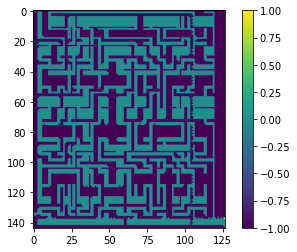

finished episode 0 with a final score of 16708.399994815438 and in 1661717 iterations
END
finished episode 1 with a final score of 104633.39999993333 and in 782467 iterations
END


KeyboardInterrupt: 

In [20]:
if __name__ == "__main__" :
    main2("F:/New folder/2.jpg", margin = 0)